# Fig. 3

**Method**

- PC1 and 2 are the 1st and 2nd principal components of the chosen cell's receptive field (spike-triggered average).


Execution time: 5 secs


TODO:
- jpg for each cell

DONE:
- tuning curves now span full meshgrid

## Setup 

setup fisher_info_limits2

In [1]:
import os
import numpy as np
import math
import scipy.io as sio
import matplotlib.pyplot as  plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from scipy.stats import wilcoxon, ks_2samp, multivariate_normal
from scipy.interpolate import griddata
import torch

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
from numba import njit, prange
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set project path
main_dir = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(main_dir)

# pipeline parameters
LOAD_METRICS = True
GRID_POS = 220

# path
CELL_DATA_PATH = 'data/contrast_cells/carlo_data_cellno2.mat' # raw cell receptive field data
METRICS_DATA_PATH = 'data/computed_contrast_cells/BDEvSSI_no2.npz' # precomputed metrics

# setup figure paraleters
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 8
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 
plt.rcParams["xtick.minor.width"] = 0.5 
plt.rcParams["ytick.major.width"] = 0.5 
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

## Functions

In [2]:
# 2D Poisson  -------------------------------------------

def SUM_LOG_LIST(position):
    '''Given an integer n it recursively calculates log(n!)'''
    if position == 0:
        return np.array([0])
    if position == 1:
        return np.append(SUM_LOG_LIST(0), 0)
    new_list = SUM_LOG_LIST(position-1)
    return np.append(new_list, new_list[-1]+np.around(np.log(float(position)), 8))


def POISSON_2DCELL(tc_grid, max_firing=20):
    log_list = np.tile(SUM_LOG_LIST(max_firing)[:,None,None], tc_grid.shape)
    log_tc = np.around(np.log(tc_grid), 8)#, where=(mask==1), out = np.ones_like(tc_grid)*-100)
    log_likelihood = (np.array([(i*log_tc-tc_grid) for i in range(max_firing+1)])-log_list)
    likelihood = np.exp(log_likelihood)
    likelihood = likelihood/np.sum(likelihood, axis=0)
    return likelihood    

    
# Neural network model of cell average response ---------------------------


class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)
    

def nnet_fit(pcs, fit, test_size=0.2, seed=42, n_epochs=200, linspace=np.linspace(-5,5,501)):
    """Fit tuning curves with a neural network

    Args:
        pcs (_type_): principal components of the cell's receptive field
        fit (_type_): tuning curve
        test_size (float, optional): _description_. Defaults to 0.2.
        seed (int, optional): _description_. Defaults to 42.
        n_epochs (int, optional): _description_. Defaults to 200.

    Returns:
        _type_: _description_
    """
    # setup reproducibility
    torch.manual_seed(seed)

    # get the predictors and predicted data
    X = np.copy(pcs[:2]).T          # x and y
    y = np.copy(np.array(fit[0]))   # response to fit
    
    # normalize principal components
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # create train/test split
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
        X_scaled, y, test_size=test_size, random_state=seed)

    # convert to tensors
    X_train = torch.tensor(X_train_np, dtype=torch.float32, requires_grad=True)
    X_test  = torch.tensor(X_test_np, dtype=torch.float32, requires_grad=True)
    y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
    y_test  = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)

    # initialize model, loss, and optimizer
    model = SimpleRegressor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 20 == 0 or epoch == 0:
            model.eval()
            val_loss = criterion(model(X_test), y_test).item()
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # inference: evaluate on a grid for visualization
    model.eval()

    # calculate grid (will be used throughout)
    grid_x, grid_y = np.meshgrid(linspace, linspace)
    grid_input = np.column_stack((grid_x.ravel(), grid_y.ravel()))
    grid_input_scaled = scaler.transform(grid_input)

    # predict response
    with torch.no_grad():
        preds = model(torch.tensor(grid_input_scaled, dtype=torch.float32)).numpy()
        
    grad_X_tensor = torch.tensor(grid_input_scaled, dtype=torch.float32, requires_grad=True)
    output = model(grad_X_tensor)
    output.backward(torch.ones_like(output))
    grads = grad_X_tensor.grad.detach().numpy()
    return preds, model, grads, grid_x, grid_y, grid_input_scaled, grid_input


#  Plots -------------------------------------------------

def scatter_hist(x, y, ax, ax_histx, ax_histy, c = 'tab:blue', alpha = 1, htype = 'step'):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y,s=1, color=c)

    # now determine nice limits by hand:
    binwidth = 0.2
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    print(xymax)
    lim = (np.rint((xymax+1)/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axx = ax_histx.hist(x, bins=bins, color=c)
    ax_histx.set_ylim(0,(axx[0].max()//100+1)*100)
    axy = ax_histy.hist(y, bins=bins, orientation='horizontal', color=c)
    ax_histy.set_xlim(0,(axy[0].max()//100+1)*100)


def plot_gaussian_ellipse(mean, cov, ax, n_std=1.0, **kwargs):
    
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)
    return ax

## Load dataset

In [3]:
%%time 

# load one cell data
mat = sio.loadmat(CELL_DATA_PATH)
np.random.seed(10)

# get tuning curve data
pcs = mat['X_lowd'] # principal components
fit = mat['f']      # average firing rate (tuning)

CPU times: user 843 ms, sys: 104 ms, total: 947 ms
Wall time: 969 ms


## Prior of PCs

### Compute 

In [4]:
%%time

# setup mean and covariance of the prior -----------------------------------

mu0 = pcs[0].mean()
mu1 = pcs[1].mean()
sigma = np.cov(pcs[0], pcs[1])

# fit the cell's tuning curve with a neural network -------------------------------

# we can get continuous predictions of average responses for arbitrary PC1 and 2 pairs
print("Fitting neural net to tuning curve data...")
preds, model, _, grid_x, grid_y, grid_input_scaled, grid_input = nnet_fit(pcs, fit)
with torch.no_grad():
    preds = model(torch.tensor(grid_input_scaled, dtype=torch.float32)).numpy()


# compute/load neural information metrics  ------------------------

# set parameters
baseline = 1e-2

# calculate prior
mus = pcs[:2].mean(axis=1)
prior = multivariate_normal(mus, sigma)
grid_prior = prior.pdf(grid_input).reshape(grid_x.shape)/prior.pdf(grid_input).reshape(grid_x.shape).sum()
prior_entropy = -np.sum(grid_prior*np.around(np.log2(grid_prior), 8))

# calculate likelihood
with torch.no_grad():
    preds = model(torch.tensor(grid_input, dtype=torch.float32)).numpy()[:,0]
tc = preds.reshape(grid_x.shape)+baseline
likelihood = POISSON_2DCELL(tc)

# calculate posterior
evidence = np.sum(likelihood*np.tile(grid_prior[None,:,:], (likelihood.shape[0],1,1)), axis=(-1,-2))
posterior = likelihood*np.tile(grid_prior[None,:,:], (likelihood.shape[0],1,1))/\
                        np.tile(evidence[:,None,None], (1,*likelihood.shape[1:])) 
posterior[posterior==0] = 1e-50
posterior = posterior/np.tile(posterior.sum(axis=(1,2))[:,None,None], (1, *grid_x.shape))

# computing is slow for 300 x 300 grid (> 1 hour)
if not LOAD_METRICS:

    # compute SSI
    post_entropy = -np.sum(posterior*np.around(np.log2(posterior),8), axis=(1,2))
    ssi = prior_entropy - np.sum(likelihood * np.tile(post_entropy[:,None,None], (1, *grid_x.shape)) ,axis=0)

    # compute Bayes error
    mse = np.empty_like(posterior[0])
    for i in range(likelihood.shape[1]):
        for j in range(likelihood.shape[2]):
            post_ij = np.sum(posterior * np.tile(likelihood[:,i,j][:,None,None], (1, *likelihood.shape[1:])), axis=0)
            delta = (grid_x - grid_x[i,j])**2+(grid_y-grid_y[i,j])**2
            mse[i,j] = np.sum(post_ij*delta)
    rmse = np.sqrt(mse)
    print("Computed SSI and Bayes error.")

else: 
    # load precomputed metrics
    out = np.load(METRICS_DATA_PATH)
    ssi = out['ssi']
    mse = out['mse']
    rmse = np.sqrt(out['mse'])
    print("mse shape: ", mse.shape)
    print("grid shape: ", out['grid_x'].shape)
    print("Loaded precomputed data:", out.keys())

# compute SSI bound
ssi_bound = 2**(prior_entropy - ssi-2*np.log2(50))/(np.sqrt(2*np.pi*math.e))

Fitting neural net to tuning curve data...
Epoch 1/200, Train Loss: 0.2139, Val Loss: 0.2523
Epoch 20/200, Train Loss: 0.0625, Val Loss: 0.1091
Epoch 40/200, Train Loss: 0.0485, Val Loss: 0.0953
Epoch 60/200, Train Loss: 0.0411, Val Loss: 0.0864
Epoch 80/200, Train Loss: 0.0366, Val Loss: 0.0807
Epoch 100/200, Train Loss: 0.0332, Val Loss: 0.0766
Epoch 120/200, Train Loss: 0.0307, Val Loss: 0.0737
Epoch 140/200, Train Loss: 0.0288, Val Loss: 0.0712
Epoch 160/200, Train Loss: 0.0274, Val Loss: 0.0692
Epoch 180/200, Train Loss: 0.0263, Val Loss: 0.0672
Epoch 200/200, Train Loss: 0.0255, Val Loss: 0.0659
mse shape:  (301, 301)
grid shape:  (301, 301)
Loaded precomputed data: KeysView(NpzFile 'data/computed_contrast_cells/BDEvSSI_no2.npz' with keys: mse, posterior, ssi, grid_x, grid_y)
CPU times: user 11.2 s, sys: 879 ms, total: 12.1 s
Wall time: 1.21 s


### Plot

5.8709399157428415
CPU times: user 122 ms, sys: 6 ms, total: 128 ms
Wall time: 127 ms


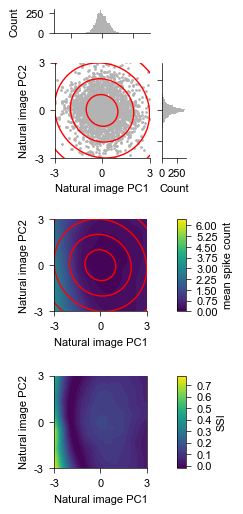

In [113]:
%%time 

xylim = (-3,3)
xyticks = (-3,0,3)

# setup plot
fig = plt.figure(figsize=(1.7,6))

# create main GridSpec: 1 col, 2 rows
# height_ratios: size of each axis
gs_main = gridspec.GridSpec(3,1, figure=fig, wspace=0, height_ratios=[1.5,1,1]) 

# Second subplot: Stimulus pcs & histogram --------------------------------------------------------------------------------

gs_top =  gridspec.GridSpecFromSubplotSpec(2, 2, 
                                           subplot_spec=gs_main[0],
                                           width_ratios=[4, 1], 
                                           height_ratios=[1, 4],
                                           hspace=0.5, wspace=0.2)

# create axes for the mosaic
axs = {}
axs['histx'] = fig.add_subplot(gs_top[0, 0])
axs['scatter'] = fig.add_subplot(gs_top[1, 0])
axs['histy'] = fig.add_subplot(gs_top[1, 1])

# plot scatter points and histograms
scatter_hist(pcs[0], pcs[1], axs['scatter'], axs['histx'], axs['histy'], c=(.7,0.7,0.7))
axs['scatter'].set_aspect('equal')
axs['scatter'].set_xlabel('Natural image PC1')
axs['scatter'].set_ylabel('Natural image PC2')
axs['scatter'].set_xlim(xylim)
axs['scatter'].set_ylim(xylim)
axs['scatter'].set_xticks(xyticks,xyticks)
axs['scatter'].set_yticks(xyticks,xyticks)

# plot prior (contours)
for n_std in np.arange(0, 5, 1):
    plot_gaussian_ellipse(np.array([mu0, mu1]), sigma, 
                         axs['scatter'], n_std=n_std, 
                         edgecolor='red', facecolor='None')

# aesthetics
axs['scatter'].spines[['top','right']].set_visible(False)
axs['histx'].spines[['top','right']].set_visible(False)
axs['histx'].set_ylabel('Count')
axs['histy'].spines[['top','right']].set_visible(False)
axs['histy'].set_xlabel('Count')

# Second subplot: Tuning curve and prior --------------------------------------------------------------------------------

ax_bottom = fig.add_subplot(gs_main[1], )

# plot tuning curve as heatmap
im = ax_bottom.contourf(grid_x, grid_y, preds.reshape(grid_x.shape), levels=50, cmap='viridis')
divider = make_axes_locatable(ax_bottom) # colorbar
cax = divider.append_axes("right", size="10%", pad=0.3)
cbar = plt.colorbar(im, cax=cax, label="mean spike count")    

# plot prior as contours
for n_std in np.arange(0, 6, 1):
    plot_gaussian_ellipse(np.array([mu0, mu1]), sigma, 
                         ax_bottom, n_std=n_std, 
                         edgecolor='red', facecolor='None')

# aesthetics
ax_bottom.set_aspect('equal')
ax_bottom.spines[['right']].set_visible(False)
ax_bottom.set_xlabel("Natural image PC1")
ax_bottom.set_ylabel("Natural image PC2")
ax_bottom.set_xlim(xylim)
ax_bottom.set_ylim(xylim)
ax_bottom.set_xticks(xyticks,xyticks)
ax_bottom.set_yticks(xyticks,xyticks)



# Third subplot: plot SSI ----------------------------------------------------

# SSI 
ax_bottom3 = fig.add_subplot(gs_main[2])
im = ax_bottom3.contourf(out['grid_x'], out['grid_y'], ssi, levels=50, cmap='viridis')
ax_bottom3.set_xlim(xylim)
ax_bottom3.set_ylim(xylim)
ax_bottom3.set_xticks(xyticks,xyticks)
ax_bottom3.set_yticks(xyticks,xyticks)
divider = make_axes_locatable(ax_bottom3) # colorbar
cax = divider.append_axes("right", size="10%", pad=0.3)
cbar = plt.colorbar(im, cax=cax, label='SSI')    
ax_bottom3.set_xlabel("Natural image PC1")
ax_bottom3.set_ylabel("Natural image PC2")
ax_bottom3.set_aspect('equal')

fig.subplots_adjust(wspace=0.9, hspace=0.5)

# # save figure
# plt.savefig('figures/fig3.svg', bbox_inches = 'tight', transparent=True, dpi=400)
# plt.savefig('figures/fig3.pdf', bbox_inches = 'tight', transparent=True, dpi=400)
# plt.savefig('figures/all/fig3.jpeg', bbox_inches = 'tight', transparent=True, dpi=400)

In [102]:
ssi.shape

(301, 301)

In [104]:
.shape

(301, 301)

In [100]:
grid_x

array([[-5.  , -4.98, -4.96, ...,  4.96,  4.98,  5.  ],
       [-5.  , -4.98, -4.96, ...,  4.96,  4.98,  5.  ],
       [-5.  , -4.98, -4.96, ...,  4.96,  4.98,  5.  ],
       ...,
       [-5.  , -4.98, -4.96, ...,  4.96,  4.98,  5.  ],
       [-5.  , -4.98, -4.96, ...,  4.96,  4.98,  5.  ],
       [-5.  , -4.98, -4.96, ...,  4.96,  4.98,  5.  ]])